# PiML Toolbox: High-code Demo for BikeSharing Data

This example notebook demonstrates how to use PiML with its high-code APIs for developing machine learning models for the BikeSharing data from UCI repository, which consists of 17,389 samples of hourly counts of rental bikes in Capital bikeshare system; see details [here](https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset). 

The response `cnt` (hourly bike rental counts) is continuous and it is a regression problem.

# Install PiML Toolbox

1. Run `!pip install piml` to install the latest version of PiML
2. In Google Colab, we need restart the runtime in order to use newly installed version

In [1]:
#!pip install piml

In [2]:
from piml import Experiment
exp = Experiment(highcode_only=True)

# Load and Prepare Data

In [3]:
# Choose BikeSharing
exp.data_loader(data='BikeSharing')

,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,cnt
0,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0000,16
1,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0000,40
2,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0000,32
3,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0000,13
4,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0000,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
17374,1,1,12,19,0,1,1,2,0.26,0.2576,0.60,0.1642,119
17375,1,1,12,20,0,1,1,2,0.26,0.2576,0.60,0.1642,89
17376,1,1,12,21,0,1,1,1,0.26,0.2576,0.60,0.1642,90
17377,1,1,12,22,0,1,1,1,0.26,0.2727,0.56,0.1343,61


In [4]:
# Exclude these features one-by-one: "season", "workingday", "atemp" (highly correlated with others)
exp.data_summary(feature_exclude=["season", "workingday", "atemp"])

Numerical Attributes 
 
 
   
 name 
 n_missing 
 mean 
 std 
 min 
 q1 
 median 
 q3 
 max 
 
 
 
 
 0 
 mnth 
 0 
 6.5378 
 3.4388 
 1.0000 
 4.0000 
 7.0000 
 10.0000 
 12.0000 
 
 
 1 
 hr 
 0 
 11.5468 
 6.9144 
 0.0000 
 6.0000 
 12.0000 
 18.0000 
 23.0000 
 
 
 2 
 weekday 
 0 
 3.0037 
 2.0058 
 0.0000 
 1.0000 
 3.0000 
 5.0000 
 6.0000 
 
 
 3 
 temp 
 0 
 0.4970 
 0.1926 
 0.0200 
 0.3400 
 0.5000 
 0.6600 
 1.0000 
 
 
 4 
 atemp 
 0 
 0.4758 
 0.1719 
 0.0000 
 0.3333 
 0.4848 
 0.6212 
 1.0000 
 
 
 5 
 hum 
 0 
 0.6272 
 0.1929 
 0.0000 
 0.4800 
 0.6300 
 0.7800 
 1.0000 
 
 
 6 
 windspeed 
 0 
 0.1901 
 0.1223 
 0.0000 
 0.1045 
 0.1940 
 0.2537 
 0.8507 
 
 
 7 
 cnt 
 0 
 189.4631 
 181.3876 
 1.0000 
 40.0000 
 142.0000 
 281.0000 
 977.0000 
 
 
 

 
 Categorical Attributes 
 
 
   
 name 
 n_missing 
 n_unique 
 top1 
 top2 
 top3 
 n_others 
 
 
 
 
 0 
 season 
 0 
 4 
 3.0 : 4496 
 2.0 : 4409 
 1.0 : 4242 
 4232 
 
 
 1 
 yr 
 0 
 2 
 1.0 : 8734 
 0.0 : 8645 
 0 
 0 
 
 
 2 
 holiday 
 0 
 2 
 0.0 : 16879 
 1.0 : 500 
 0 
 0 
 
 
 3 
 workingday 
 0 
 2 
 1.0 : 11865 
 0.0 : 5514 
 0 
 0 
 
 
 4 
 weathersit 
 0 
 4 
 1.0 : 11413 
 2.0 : 4544 
 3.0 : 1419 
 3

Data Shape:(17379, 13)


In [5]:
# Prepare dataset by setting target, task type and train-test split
exp.data_prepare(target='cnt', task_type='regression', test_ratio=0.2, random_state=0)

,Config,Value
0,Excluded columns,"[atemp, workingday, season]"
1,Target variable,cnt
2,Sample weight,None
3,Task type,regression
4,Split method,random
5,Test ratio,0.2
6,Random state,0


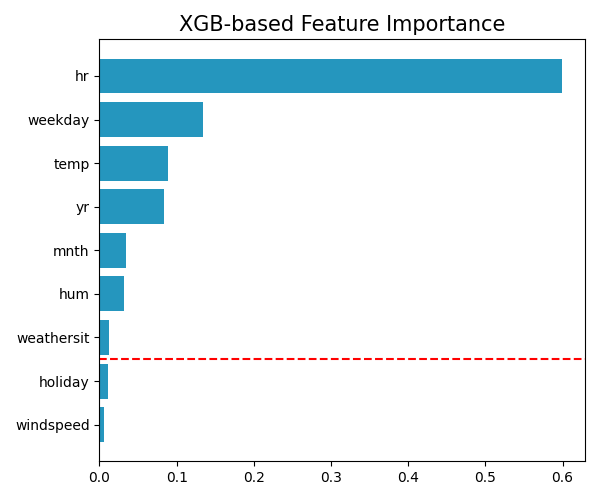

In [6]:
# Optional: select features by LightGBM feature importance 
exp.feature_select(threshold=0.98, method="pfi", figsize=(6, 5))

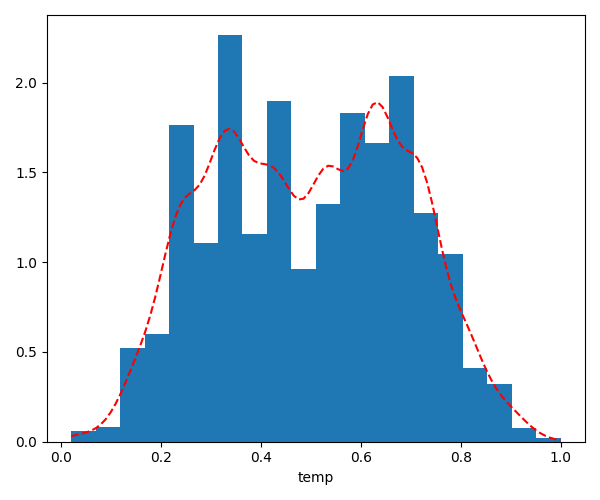

In [7]:
# Exploratory data analysis, check distribution and correlation
exp.eda(show='univariate', uni_feature='temp', figsize=(6, 5))

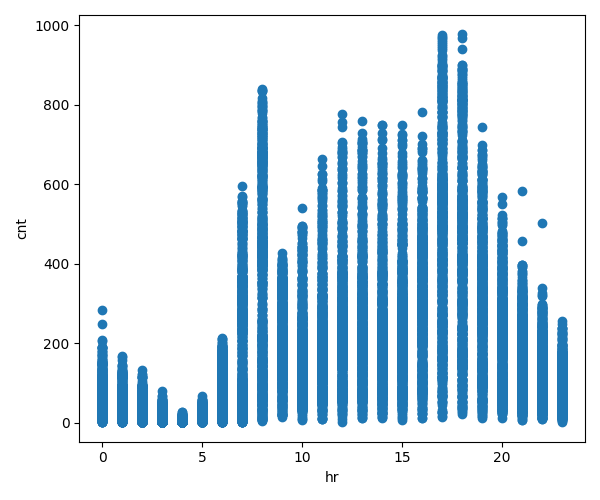

In [8]:
exp.eda(show='bivariate', bi_features=['hr', 'cnt'], figsize=(6, 5))

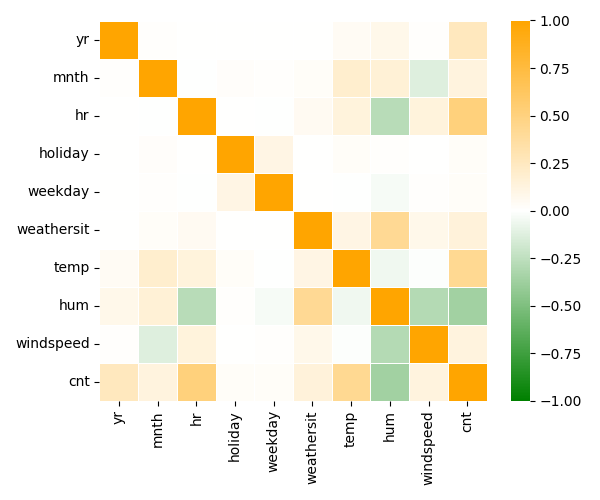

In [9]:
exp.eda(show='multivariate', multi_type='correlation_heatmap', figsize=(6, 5))

# Train intepretable models

In [10]:
## ReLU-DNN: ReLU Deep Neural Networks with L1-Regularization
from piml.models import ReluDNNRegressor

model1 = ReluDNNRegressor(hidden_layer_sizes=(40, 40), l1_reg=1e-05,
                        batch_size=500, learning_rate=0.001)
exp.model_train(model=model1, name='ReLU-DNN')
exp.model_diagnose(model="ReLU-DNN", show='accuracy_table')

,MSE,MAE,R2
,,,
Train,0.0033,0.0379,0.9053
Test,0.0037,0.0403,0.8940
Gap,0.0005,0.0024,-0.0113


In [11]:
## GAMI-Net: GAM-Neural Networks with Structured Interactions
from piml.models import GAMINetRegressor

model2 = GAMINetRegressor(interact_num=10, loss_threshold=0.01,  
                        subnet_size_main_effect=[20], 
                        subnet_size_interaction=[20,20])
exp.model_train(model=model2, name='GAMI-Net')
exp.model_diagnose(model="GAMI-Net", show='accuracy_table')

,MSE,MAE,R2
,,,
Train,0.0034,0.0394,0.9014
Test,0.0037,0.0420,0.8932
Gap,0.0003,0.0026,-0.0082


In [ ]:
## EBM: Explainable Boosting Machine from MS Research
from piml.models import ExplainableBoostingRegressor

model3 = ExplainableBoostingRegressor(interactions=10, random_state=0)
exp.model_train(model=model3, name='EBM')
exp.model_diagnose(model="EBM", show='accuracy_table')

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='accuracy_plot', metric="MSE", figsize=(6, 5))

# Explainability and Interpretability

## Post-hoc Explainability: Global and Local Methods

In [ ]:
exp.model_explain(model='GAMI-Net', show='pfi', figsize=(6, 5))

In [ ]:
exp.model_explain(model='GAMI-Net', show='pdp', uni_feature='hr', figsize=(6, 5))

In [ ]:
exp.model_explain(model='GAMI-Net', show='ice', uni_feature="hr", figsize=(6, 5))

In [ ]:
exp.model_explain(model='GAMI-Net', show='ale', bi_features=['hr', 'weekday'], figsize=(6, 5))

In [ ]:
exp.model_explain(model='GAMI-Net', show='shap_fi', sample_size=20, figsize=(6, 5))

In [ ]:
exp.model_explain(model='GAMI-Net', show='shap_summary', sample_size=20, figsize=(6, 5))

In [ ]:
exp.model_explain(model='GAMI-Net', show='shap_waterfall', sample_id=0, figsize=(6, 5))

In [ ]:
exp.model_explain(model='GAMI-Net', show='lime', sample_id=0, figsize=(6, 5))

## Inherent Interpretability: Global and Local Methods
 


In [ ]:
exp.model_interpret(model='GAMI-Net', show='global_fi', figsize=(6, 5))

In [ ]:
exp.model_interpret(model='GAMI-Net', show='global_effect_plot', uni_feature='hr', figsize=(6, 5))

In [ ]:
exp.model_interpret(model='GAMI-Net', show='local_fi', sample_id=0, figsize=(6, 5))

# Model Diagnostics and Outcome Testing

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='accuracy_table')

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='accuracy_residual', show_feature='hr', figsize=(6, 5))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='weakspot', slice_features=['hr'], 
                   slice_method='tree', threshold=1.2, min_samples=20, figsize=(6, 5))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='weakspot', slice_features=['hr', 'weekday'], 
                   slice_method='histogram', threshold=1.2, min_samples=20, figsize=(6, 5))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='weakspot', slice_features=['hr', 'weekday'], return_data=True,
                   slice_method='histogram', threshold=1.2, min_samples=20, figsize=(6, 5))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='overfit', slice_features=['hr'], 
                   slice_method='histogram', threshold=1.1, min_samples=20, figsize=(6, 5))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='reliability_marginal', alpha=0.1, 
                   show_feature='hr', threshold=1.2, bins=10, figsize=(6, 5))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='robustness_perf', perturb_features=None, perturb_size=0.01, figsize=(6, 5))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='resilience_perf', show_feature='hr', figsize=(6, 5))

In [ ]:
exp.model_diagnose(model='GAMI-Net', show='resilience_shift_density', immu_feature='hr', show_feature='hr', alpha=0.2, figsize=(6, 5))

# Model Comparison and Benchmarking

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='reliability_coverage', alpha=0.1, figsize=(6, 5))

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='reliability_bandwidth', alpha=0.1, figsize=(6, 5))

In [ ]:
exp.model_diagnose(model='ReLU-DNN', show='reliability_table', alpha=0.1, figsize=(6, 5))

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='robustness_perf', 
                  perturb_features=None, perturb_size=0.01, figsize=(6, 5))

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='robustness_perf_worst', 
                  perturb_features=None, perturb_size=0.01, alpha=0.2, figsize=(6, 5))

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='resilience_perf', figsize=(6, 5))

In [ ]:
exp.model_compare(models=['ReLU-DNN', 'GAMI-Net', 'EBM'], show='resilience_distance', figsize=(6, 5))